In [1]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import t, sem
from scipy.stats import linregress
import scipy.signal
from tqdm.autonotebook import tqdm as notebook_tqdm

import pandas as pd
import seaborn as sns

import sys
sys.path.append('../..')
import dynaphos
from dynaphos import utils


params = utils.load_params('../../config/params.yaml')


# plt.rcParams.update({'axes.labelsize': 'large'})
plt.rcParams.update({
    'axes.labelsize': 'large',
    'font.size': 18})

dark_plots = False
if dark_plots:
    plt.style.use('dark_background')
    neutral_color = 'w'
else:
    neutral_color = 'k'
# plt.rcParams.update({'style': 'seaborn'})

# c_list = [color1,color2,color3,color4]
#colors for plots, to fit with theme for prettiness
color1 = '#326e5e' #dark-turquoise
color2 = '#63c4ab' #turquoise
color3 = '#AFE4DE'

c_list_turq = [color1,color2,color3]

#donders color scheme
color1 = '#8b0203' #dark red
color2 = '#ba1319' #medium red
color3 = '#ed1c24' #light red
color4 = '#dd8a8d' #very light red (light red low opacity)

c_list_red = [color1,color2,color3,color4]

/tmp/ipykernel_12471/2792724762.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm as notebook_tqdm


## Import data from Schmidt *et al.* (1996)

In [2]:
DATA_SCHMIDT = pd.read_csv('data/Schmidt_et_al_1996.csv')

## Generating input trains

#### STIMULATION_SEQUENCE_1   (short-term effects)

Prolonged stimulation (3s) with low or high stimulation amplitude.  
Observations (Schmidt): slightly delayed onset, slightly longer duration than stimulation, but maximum duration of 930/2760 ms 
this should also show saturation in activation amplitude

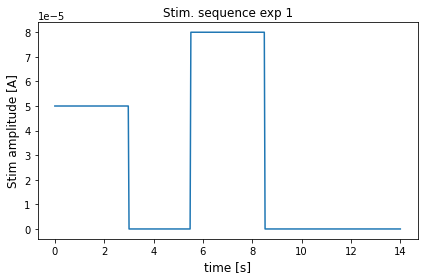

In [3]:
#parameters
fps = 32 #we only simulate stimulation when a frame is generated right now
dt = 1/fps #size of timestep

#experiment 1: short-term effects
# what Schmidt says: slightly delayed onset, slightly longer duration than stimulation, but maximum duration of 930/2760 ms (depends on stimulation protocol)
# this should also show saturation in activation amplitude
T_1 = 14 # total simulation time in s
n_steps = int(T_1/dt)
train_length = int(3/dt)
stim = np.zeros(n_steps) #input

#four types of input: low, high & intermittent and increasing, with gaps inbetween
pause_length = int((n_steps-3*train_length)/2)
step = train_length + pause_length
stim[0:train_length] = 50e-6 #set inputs
stim[step:step+train_length] = 80e-6
# stim[step*2:step*2+train_length:4] = 30e-6
# stim[step*3:step*3+train_length] = np.linspace(5,30,train_length)

X_IN_1 = stim.copy()

# visualize
time = np.linspace(0,T_1,n_steps)
plt.plot(time, X_IN_1,)
plt.xlabel('time [s]')
plt.ylabel('Stim amplitude [A]')
plt.title('Stim. sequence exp 1')
plt.tight_layout()

STIMULATION_SEQUENCE_EXP1 = stim.copy()

#### STIMULATION_SEQUENCE_2  (Longer-term effects)

 Repeated stimulation over a time course of 1201 seconds. The first 200 seconds consisted of 50 stimulation trains with a 4 second interval. In the last 1000 seconds the inter-stimulation interval was longer (200s).

Observations (Schmidt): accomodation of the brightness with a recovery time in the order of several minutes. Schmidt figures 5&6. 

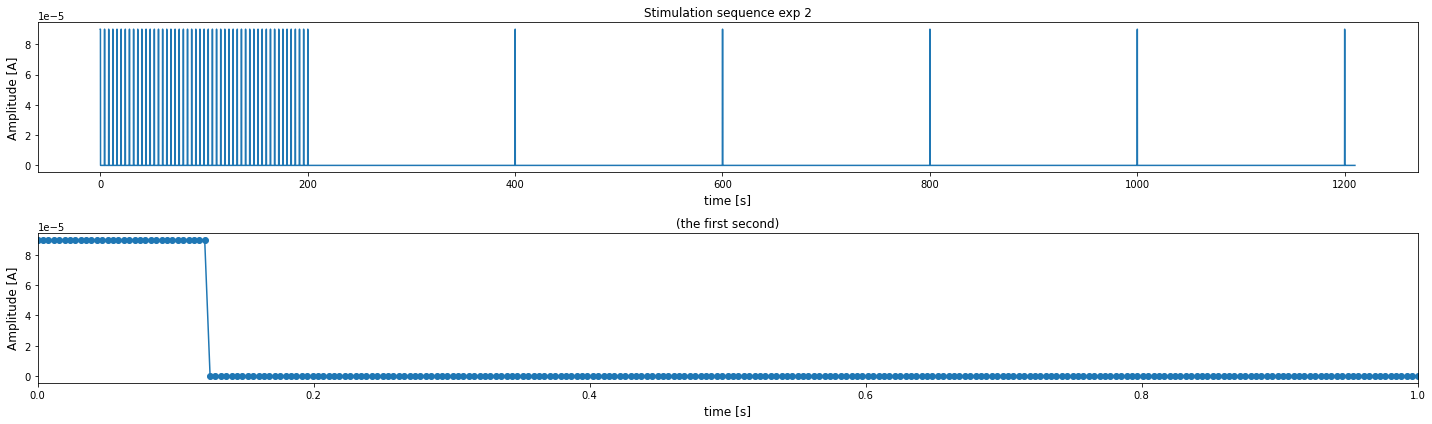

In [4]:
STIM_AMPLITUDE = 90e-6 # 90e-6 # NOTE: higher than in Schmidt paper, but with the given brightness fit, we need a reasonable value to start with

## Stimulation sequences for 1200 seconds 
fps = 256
total_duration = 1210 #seconds
train_duration = .125 #seconds
time = np.linspace(0,total_duration,fps*total_duration)
stim_moments = np.concatenate([np.linspace(0,200,50, endpoint=False), # Fast part
                              np.linspace(200,1200,6, endpoint=True)]) # Slow part


stim_frames = int(fps*train_duration) # number of consecutive stimulation frames
stim = np.zeros(fps*total_duration)
for t in stim_moments:
    idx = int(t*fps)
    stim[idx:idx+stim_frames] = np.ones(stim_frames) * STIM_AMPLITUDE

# visualize
_, ax = plt.subplots(2,1,figsize=(20,6))
ax[0].plot(time, stim,)
ax[0].set(xlabel = 'time [s]',
          ylabel = 'Amplitude [A]',
          title  = 'Stimulation sequence exp 2')
ax[1].plot(time, stim,'-o')
ax[1].set(xlabel = 'time [s]',
          ylabel = 'Amplitude [A]',
          title  = '(the first second)',
          xlim   = [0,1])
plt.tight_layout()

STIMULATION_SEQUENCE_EXP2 = stim.copy()
FRAMERATE_EXP2 = fps

### Visualization of accomodation over time 
Demo of accomodation of the activation and other temporal dynamics over time, for one electrode.

Text(0.5, 0, 'time (s)')

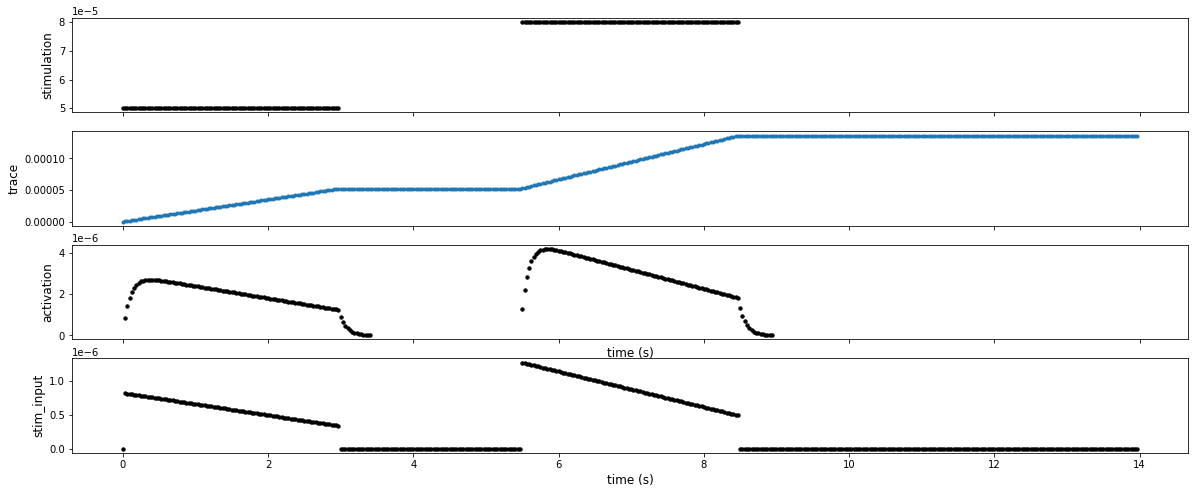

In [5]:
#initialize
stim = STIMULATION_SEQUENCE_EXP1.copy() #input
n_steps = len(stim)
T = n_steps*dt

stim_input = np.zeros(n_steps)
trace = np.zeros(n_steps) #memory trace
activation = np.zeros(n_steps) #output


# parameters (slow habituation)
rheobase = 2.39e-05
a = -np.log(0.9995) #decay of memory
b = 0.35 # how much new input increases the memory trace
c = 9.  #decay of activation
d = .3 #effect of new input and trace
    
    
## UNCOMMENT FOR FAST HABITUATION 
# rheobase = 2.39e-05
# a = 1.4 #decay of memory -- corresponds with (1 - 0.96)/dt (framerate 35fps)
# b = 0.35 # how much new input increases the memory trace  -- corresponds with 0.01/dt (framerate 35fps)
# c = 21  #decay of activation -- corresponds with (1 - 0.4)/dt (framerate of 35fps)
# d = 1. #effect of new input and trace

#run experiment
for t in np.arange(1,n_steps):
    
    # remainder after decay from previous time step
    activation[t] = activation[t-1] 
    activation[t] -= c * activation[t-1] * dt
    
    # new input
    stim_input[t] = (stim[t] - d*trace[t-1] - rheobase) * dt 
    stim_input[t] = max(0,stim_input[t])
    activation[t] += stim_input[t]
    
    # trace update 
    trace[t] = trace[t-1]
    trace[t] -= a * trace[t-1] * dt
    trace[t] += b * stim[t] * dt


# Visualize
stim[stim==0] = np.nan
activation[activation<1e-8] = np.nan
fig, axs = plt.subplots(4,1,figsize=(20,8),sharex=True)
axs.ravel()
time = np.arange(0,T,dt)
axs[0].scatter(time,stim,marker='.',c=neutral_color,s=45)
axs[0].set_ylabel('stimulation')
axs[1].scatter(time,trace,marker='.')
axs[1].set_ylabel('trace')
axs[2].scatter(time,activation,marker='.',c=neutral_color,s=45)
axs[2].set_ylabel('activation')
axs[2].set_xlabel('time (s)')

axs[3].scatter(time,stim_input,marker='.',c=neutral_color,s=45)
axs[3].set_ylabel('stim_input')
axs[3].set_xlabel('time (s)')

# Fitting curve to Schmidt *et al.* (1996)

In [6]:
# import sys
# sys.path.append('./..')
# import utils
# from simulator import GaussianSimulator as PhospheneSimulator
# import init

params = utils.load_params('../../config/params.yaml')

In [7]:
SIGMOID = lambda x: 1/(1+np.exp(-x))
ACT_DECAY = params['temporal_dynamics']['activation_decay_per_second']

def brightness_func(activation,
                    slope = 36279530.38871381,
                    I_half = 5.5862273679415555e-08):
    y = SIGMOID(slope*(activation - I_half))
    return y

def func_curve_fit(x, trace_decay_per_sec, trace_increase_rate):
    """ Wrapper function of the 'run_experiment' function that takes only two parameters and the 
    stimulation sequence as input, and returns only the output activation at the time points specified in x"""
    
    # Using default parameters
    act_decay_per_sec = ACT_DECAY # decay per second
    act_decay_constant = -np.log(act_decay_per_sec)
    trace_decay_constant = -np.log(trace_decay_per_sec) # decay per second
    
    # Run the experiment with the full stimulation sequence to r
    # (this sequence includes the interpolated time points in the schmidt figure)
    brightness, activation, trace, stim = run_experiment(STIMULATION_SEQUENCE_EXP2,
                                             trace_decay_constant,
                                             trace_increase_rate,
                                             act_decay_constant,
                                             dt=1/FRAMERATE_EXP2)
    # Normalize the output
    brightness = brightness/brightness.max()
    
       
    # Extract the peaks in activation matching the time points in the schmidt data
#     brightness[0] = 0. # Make the first element zero, otherwise the first peak is not counted as peak..
    peaks, _ = scipy.signal.find_peaks(brightness)
    y = brightness[peaks]
    
#     print(f'found {len(peaks)} peaks for trace_increase_rate {trace_increase_rate}')
#     print(f'peaks at: {peaks/FRAMERATE_EXP2} \nactivation: {activation} \ny: {y}')
    assert len(x) == len(peaks)  # all peaks should match a stim moment
    
    return y


def run_experiment(X_IN,
                trace_decay_constant,
                trace_increase_rate,
                act_decay_constant = -np.log(ACT_DECAY),
                rheobase = 23.9e-6,
                pulse_width = 100e-6,
                frequency = 200,
                dt = 1/32,):
    
    # Stimulation sequence
    stim = X_IN.copy()
    n_steps = len(stim)
    T = n_steps*dt

    # Initialize output arrays
    stim_input = np.zeros(n_steps) # JR: effective stimulation
    trace = np.zeros(n_steps) #long-term memory trace
    activation = np.zeros(n_steps) #output
    leak = np.zeros(n_steps)

    
    activation_ = 0
    trace_ = 0.
    
    #run experiment
    for t in notebook_tqdm(range(n_steps)):
        
        ## TODO: REMOVE!!!
#         trace = np.zeros(n_steps) 
        
        
        if t>0:
            # remainder after decay from previous time step
            activation[t] = activation[t-1]
            activation[t] -= act_decay_constant * activation[t-1] * dt

            # new input
            leak_current  = trace[t-1] + rheobase
            stim_input[t] = (stim[t] - leak_current) * pulse_width * frequency 
            stim_input[t] = max(0,stim_input[t]) 
            activation[t] += stim_input[t] * dt 

            # trace update 
            trace[t] = trace[t-1]
            trace[t] -= trace_decay_constant * trace[t-1] * dt
            trace[t] += trace_increase_rate * stim_input[t] * dt
            
            leak[t]  = leak_current
            
        else:
            # In the first frame, ignore the previous time step (there is none)
            stim_input[t] = (stim[t] - rheobase) * pulse_width * frequency * dt 
            stim_input[t] = max(0,stim_input[t])
            activation[t] += stim_input[t]
            
            leak[t]  = rheobase
            
        
    brightness = brightness_func(activation)
    
    return brightness, activation, trace, stim #, stim_input, leak





100%|███████████████████████████████| 309760/309760 [00:01<00:00, 293554.90it/s]


PARAMS: decay_per_sec = 0.999492, trace_increase: 13.955281


100%|███████████████████████████████| 309760/309760 [00:01<00:00, 281709.69it/s]


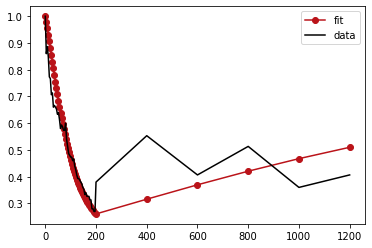

In [8]:
popt, pcov = curve_fit(func_curve_fit,
                       DATA_SCHMIDT.time,
                       DATA_SCHMIDT.y_mean,
                       p0 = [.9995, 15],
                       bounds = ([0,0],[1-1e-12,100]))

print("PARAMS: decay_per_sec = {:.6f}, trace_increase: {:.6f}".format(*popt))
plt.plot(DATA_SCHMIDT.time, func_curve_fit(DATA_SCHMIDT.time, *popt), '-o', c=c_list_red[1],label='fit')
plt.plot(DATA_SCHMIDT.time, DATA_SCHMIDT.y_mean, '-', c=neutral_color, label='data')
plt.legend()
plt.show()

In [9]:
def plot_exp_A(activation, trace, stim):

    # Normalize
#     activation = activation/activation.max()
#     trace = trace/trace.max()
    
    # Remove zeros
    stim[stim==0] = np.nan
    activation[activation==0] = np.nan

    # time
    n_steps = len(stim)
    T = n_steps*dt
    time = np.linspace(0,T,n_steps)
    
    ## Plot figures
    fig, axs = plt.subplots(3,1,figsize=(21,5),sharex=True)
    axs.ravel()
    
    # Stimulation
    axs[0].scatter(time,stim[:n_steps]*1e6,marker='.',c=neutral_color,s=55, label='stimulation')
    axs[0].set(ylabel ='intensity ($\mu$A)',
               ylim   = [0,90])
    axs[0].legend()
    
    # Trace 
    axs[1].plot(time,trace[:n_steps],c=color1, lw=3, label='trace')
    axs[1].set_ylabel('trace')
    axs[1].legend()
    
    # Activation
    axs[2].scatter(time,activation[:n_steps],marker='.',c=neutral_color,s=55,label='phosphene')
    axs[2].set(ylabel = 'brightness',
               xlabel = 'time (s)',
#                ylim   = [0,1e5]
              )
    axs[2].legend()
    
    
    plt.tight_layout()
    plt.show()


def plot_schmidt_repro(activation,
                      ):
  
    # Normalize and remove zeros
    activation = activation/activation.max()
    

    ## Perform regression
    
    # True data
    x = DATA_SCHMIDT.time
    y_true = DATA_SCHMIDT.y_mean
    conf_95 = (DATA_SCHMIDT.conf_95_lower, DATA_SCHMIDT.conf_95_upper)
    
    # Estimated data
    # y_pred is the peak in activation corresponding to stimulation point x
    peaks, _ = scipy.signal.find_peaks(activation) # Extract the peaks in activation matching the time points in the schmidt data
    y_pred = activation[peaks]    
    print(f"On average, the peak in activation occured {(peaks-x*fps).mean()} frames after stimulation")
    
    # linear regression
    regres = linregress(y_true,y_pred)
    print(f"R^2: {regres.rvalue}")

    ## Plot figures
    fig, axs = plt.subplots(2,1,figsize=(12,10), dpi=300,sharey=True)
    axs = axs.ravel()

    # First plot only the first 50 series of stimulation, then plot the total sequence
    for i, n in enumerate([50, len(x)]):
        axs[i].fill_between(x[:n], conf_95[0][:n], conf_95[1][:n],color=c_list_turq[2], label='95% confidence interval')
        axs[i].plot(x[:n], y_true[:n], '--', c=c_list_turq[0], label='mean of data')
        axs[i].plot(x[:n], y_pred[:n],'-o', c=c_list_red[1], label='model prediction')

        axs[i].set(ylabel = 'Brightness (relative)',
                   xlabel = 'Time [s]',
                   ylim   = [0,1.1],)

        # Re-order legend 
        handles, labels = axs[i].get_legend_handles_labels()
        handles = [handles[0],handles[2],handles[1]]
        labels = [labels[0],labels[2],labels[1]]
        axs[i].legend(handles, labels)
    
    plt.tight_layout()
    plt.show()
    
    return fig, axs

100%|█████████████████████████████████████| 448/448 [00:00<00:00, 285569.63it/s]


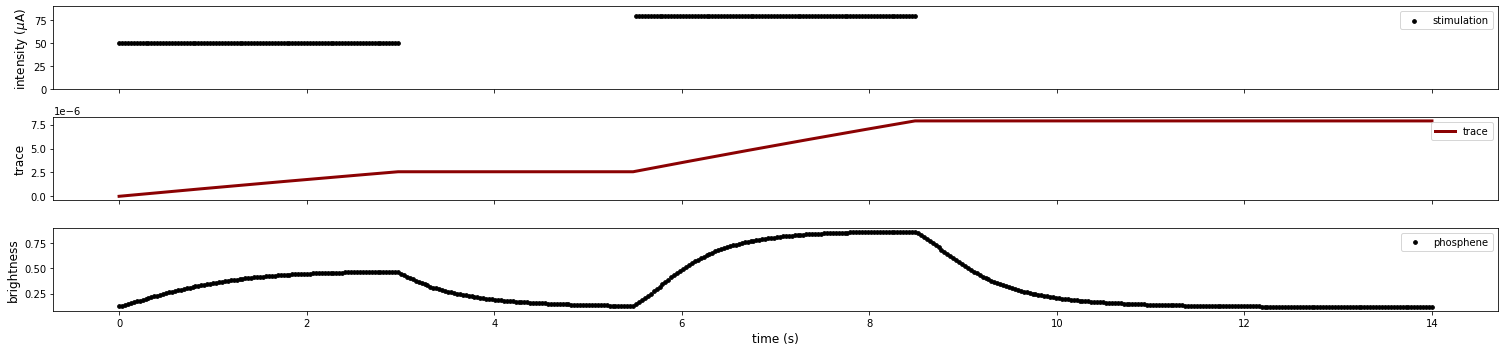

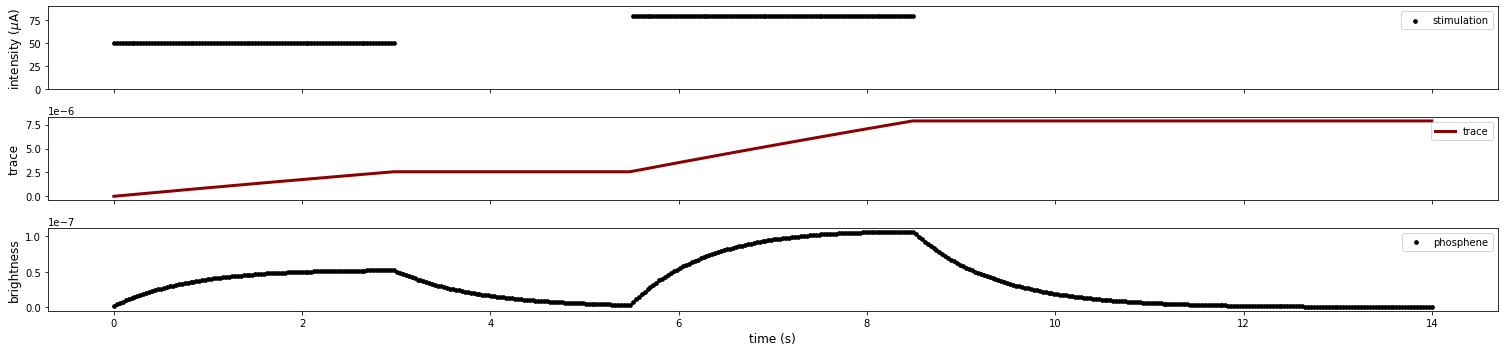

100%|███████████████████████████████| 309760/309760 [00:01<00:00, 290581.62it/s]


On average, the peak in activation occured 31.0 frames after stimulation
R^2: 0.9620029075202092


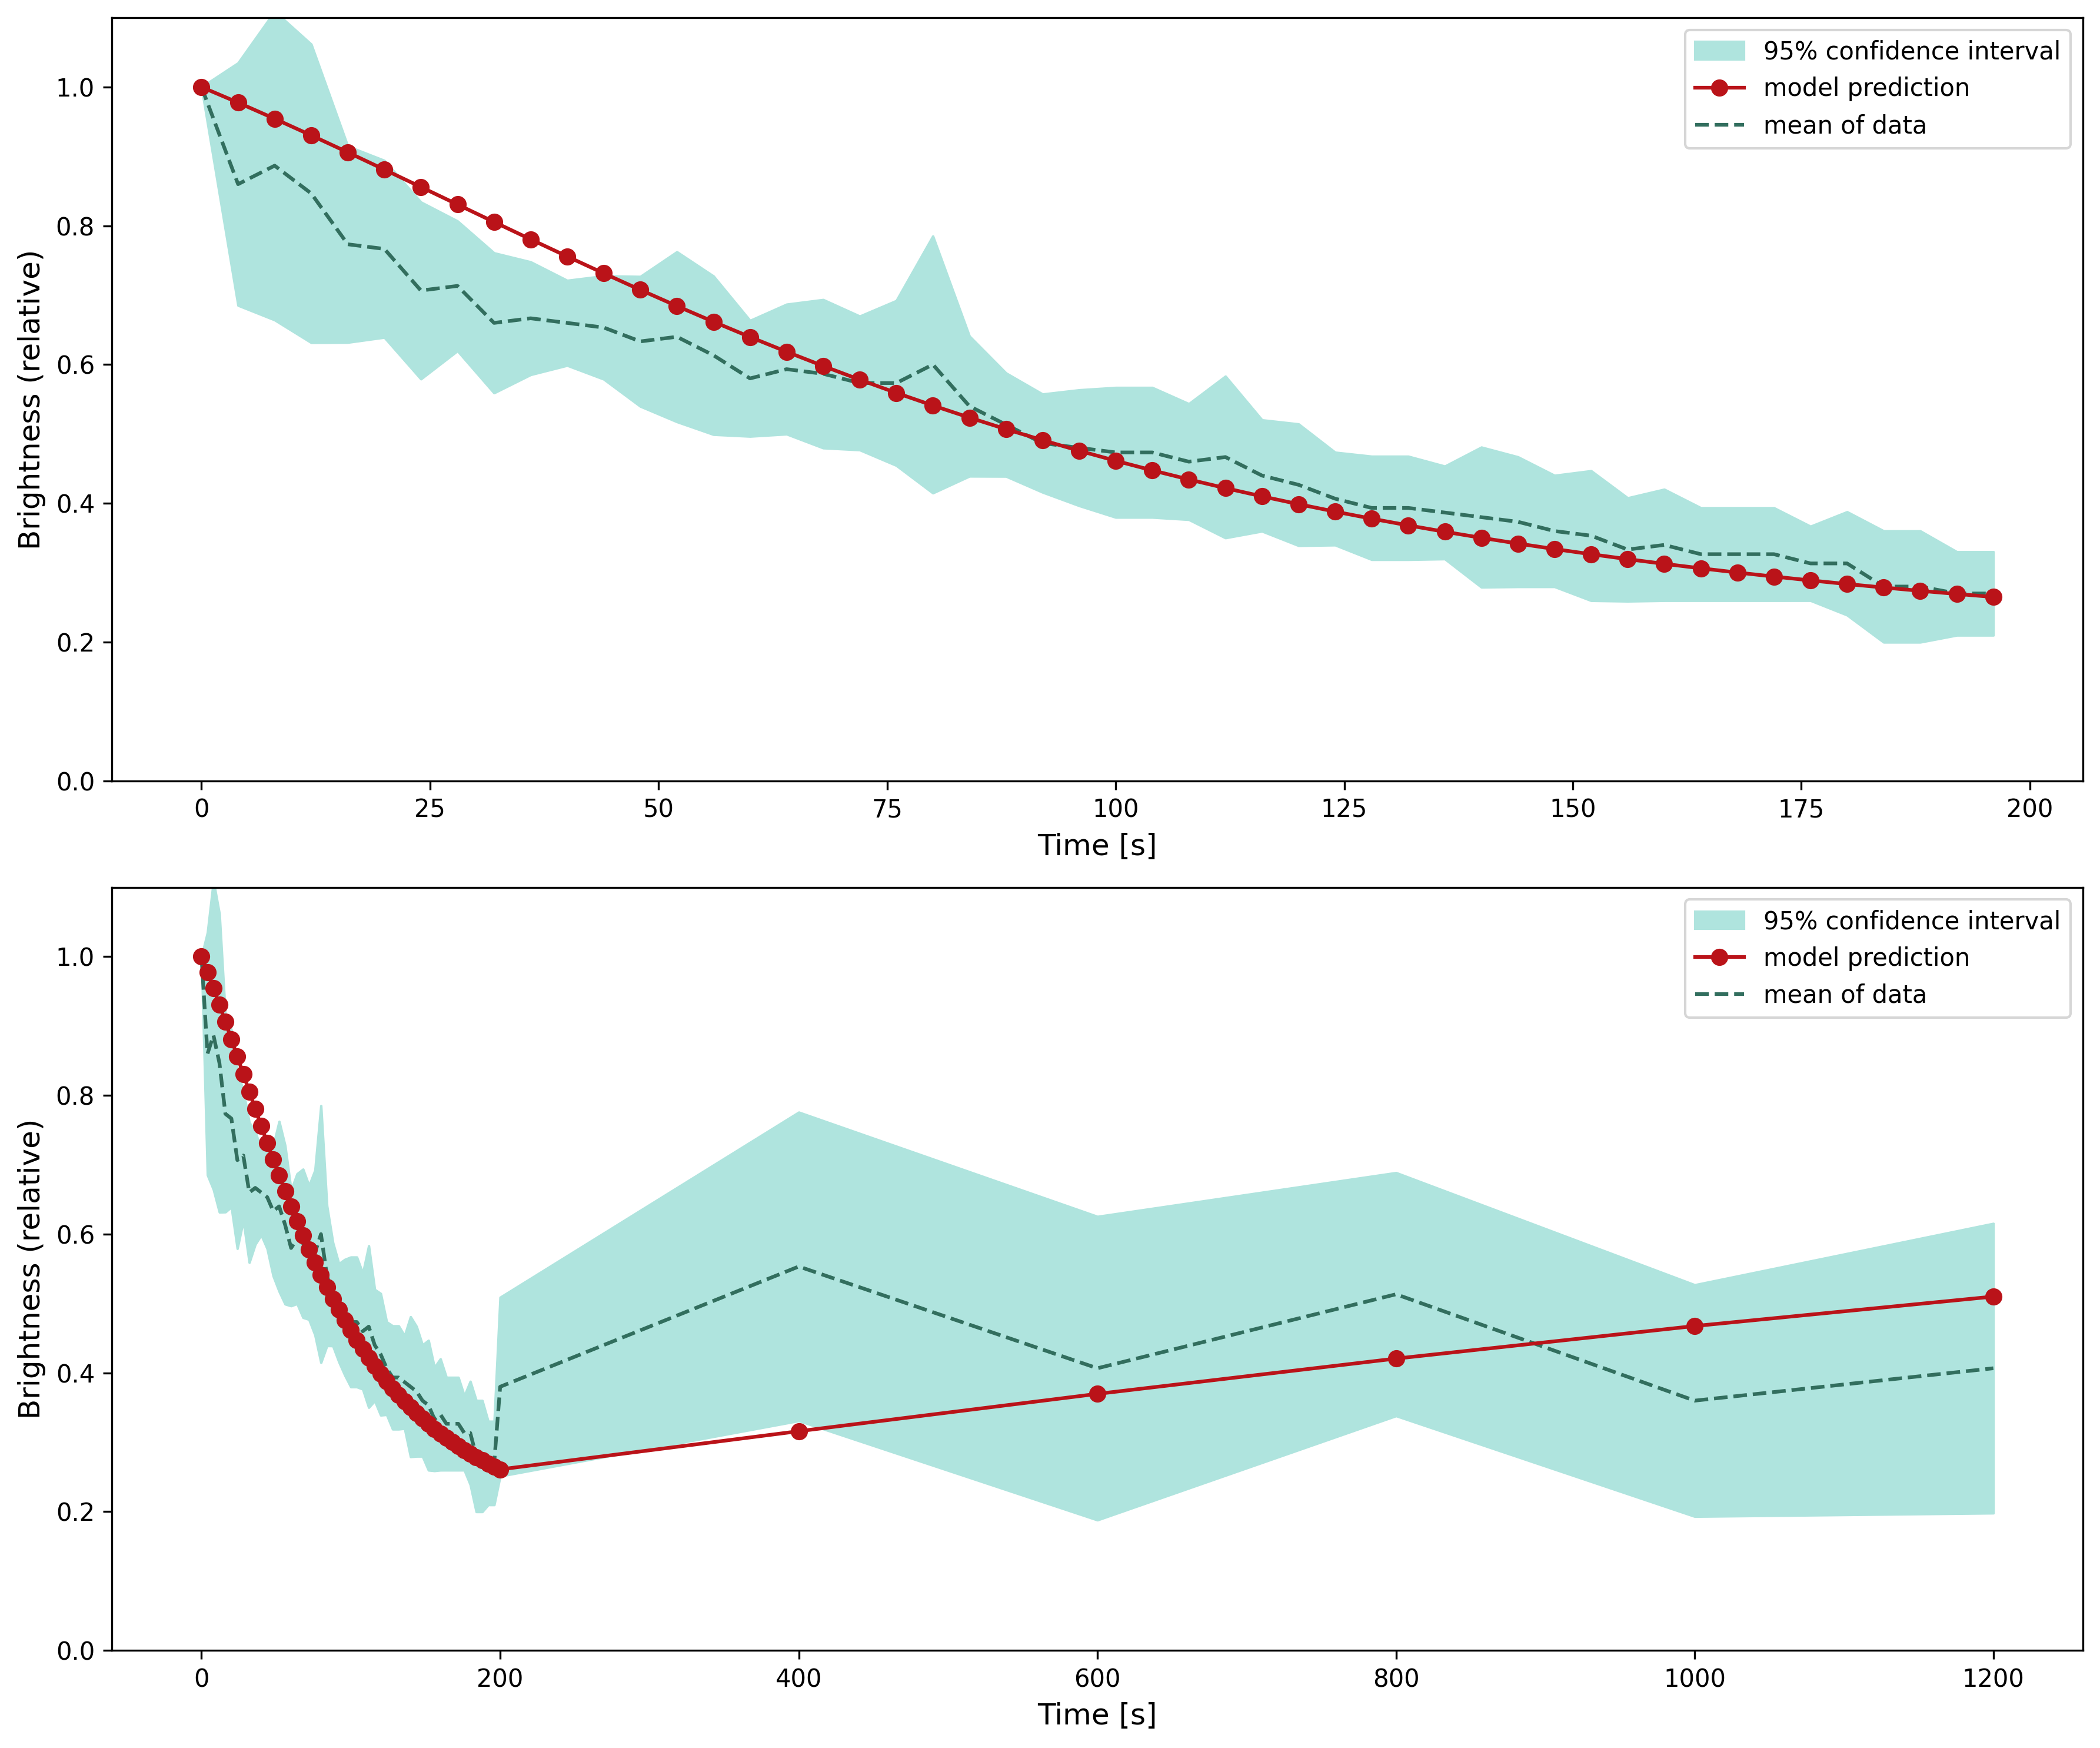

(<Figure size 3600x3000 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time [s]', ylabel='Brightness (relative)'>,
        <AxesSubplot:xlabel='Time [s]', ylabel='Brightness (relative)'>],
       dtype=object))

In [10]:
# temporal dynamics parameters
trace_decay_per_sec, trace_increase_rate = popt
activation_decay_per_sec = params['temporal_dynamics']['activation_decay_per_second']


# decay constants
trace_decay_constant = -np.log(trace_decay_per_sec)
act_decay_constant   = -np.log(activation_decay_per_sec)


# Experiment A 
brightness, activation, trace, stim = run_experiment(STIMULATION_SEQUENCE_EXP1,
                                       trace_decay_constant,
                                       trace_increase_rate,
                                       act_decay_constant,
                                       rheobase = 23.9e-6,
                                       pulse_width = 100e-6,
                                       frequency = 200,
                                       dt = 1/256)
plot_exp_A(brightness, trace, stim)

plot_exp_A(activation, trace, stim)

# Experiment B
brightness, activation, trace, stim = run_experiment(STIMULATION_SEQUENCE_EXP2,
                                         trace_decay_constant,
                                         trace_increase_rate,
                                         act_decay_constant,
                                         rheobase = 23.9e-6,
                                         pulse_width = 100e-6,
                                         frequency = 200,
                                         dt = 1/256)                                        

plot_schmidt_repro(brightness)

# plot_schmidt_repro(activation)


# Verify using  the actual simulator model

In [18]:
import sys
sys.path.append('./../..')
from dynaphos import utils
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
# import init
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map, get_visual_field_coordinates_probabilistically 


import torch


# from tqdm import tqdm_notebook

In [19]:
# ## Stimulation sequences for 1200 seconds 
# total_duration = 1210 #seconds
# train_duration = .125 #seconds
# stim_moments = np.concatenate([np.linspace(0,200,50, endpoint=False), # Fast part
#                               np.linspace(200,1200,6, endpoint=True)]) # Slow part

# fps1 = 256
# stim_frames = int(fps1*train_duration) # number of consecutive stimulation frames
# stim_sequence1 = torch.zeros(fps1*total_duration)
# for t in stim_moments:
#     idx = int(t*fps1)
#     stim_sequence1[idx:idx+stim_frames] = torch.ones(stim_frames) * 50e-6

# fps2 = 48
# stim_frames = int(fps2*train_duration) # number of consecutive stimulation frames
# stim_sequence2 = torch.zeros(fps2*total_duration)
# for t in stim_moments:
#     idx = int(t*fps2)
#     stim_sequence2[idx:idx+stim_frames] = torch.ones(stim_frames) * 50e-6
    
# _, axs = plt.subplots(2,1, figsize = (20,5), sharex=True)

# axs[0].plot(np.linspace(0,total_duration,total_duration*fps1), stim_sequence1.numpy(),'.')
# axs[0].set(xlim = (0,4.5),
#             title=f'stimulation sequence 1 (fps: {fps1})', xlabel='time [s]', ylabel='Amplitude [A]')
# axs[1].plot(np.linspace(0,total_duration,total_duration*fps2), stim_sequence2.numpy(),'.')
# axs[1].set(xlim = (0,4.5),
#            title=f'stimulation sequence 2 (fps: {fps2})', xlabel='time [s]', ylabel='Amplitude [A]')
# plt.tight_layout()
# plt.show()

In [24]:
params = utils.load_params('../../config/params.yaml')

# Testing with few phosphenes:
params['cortex_model']['dropout_rate'] = 0


# TODO use params from schmidt: F = 200 Hz, PD =100 us, IPI = 100 us, TL = 125 ms

# params['thresholding']['rheobase'] = 0 #23.9e-6
params['default_stim']['pw_default'] = 100e-6
params['default_stim']['freq_default'] = 200
params['run']['gpu'] = None

# Simulator 1
params['run']['fps'] = FRAMERATE_EXP2
params['thresholding']['use_threshold'] = False
coordinates_visual_field = get_visual_field_coordinates_probabilistically(params,n_phosphenes=1)
simulator = PhospheneSimulator(params.copy(), coordinates_visual_field)
n_phosphenes = simulator.num_phosphenes
device = simulator.phosphene_maps.device

states=[]
stim_sequence = torch.from_numpy(STIMULATION_SEQUENCE_EXP2)
for i,stim in notebook_tqdm(enumerate(stim_sequence), total=len(stim_sequence)):
    simulator.update(stim)
    states.append({k:v.item() for k,v in simulator.get_state().items()})


# # Visualize the results    
results = pd.DataFrame(states)
results['stimulation'] = stim_sequence.cpu().numpy()
results['fps'] = params['run']['fps']
results['time'] = results.index.copy() / results.fps



_,ax = plt.subplots(1,1,figsize=(25,5), sharex = True)
peaks, _ = scipy.signal.find_peaks(results.brightness)
ax.plot(results.time,results.brightness, label ='brightness')
ax.plot(results.time[peaks],results.brightness[peaks], '.', label='peaks' )
ax.set(title= f'framerate: {results.fps[0]}', ylabel='brightness')
ax.legend()

plt.tight_layout()
plt.show()

fig, axs = plot_schmidt_repro(results.brightness)

100%|█████████████████████████████████| 309760/309760 [00:42<00:00, 7355.51it/s]


AttributeError: 'GaussianSimulator' object has no attribute 'run'

In [35]:
# True data
x = DATA_SCHMIDT.time
y_true = DATA_SCHMIDT.y_mean
conf_95 = (DATA_SCHMIDT.conf_95_lower, DATA_SCHMIDT.conf_95_upper)

# Estimated data
# y_pred is the peak in activation corresponding to stimulation point x
peaks, _ = scipy.signal.find_peaks(results.brightness) # Extract the peaks in activation matching the time points in the schmidt data
y_pred = results.brightness[peaks]    
print(f"On average, the peak in activation occured {(peaks-x*fps).mean()} frames after stimulation")

# linear regression
regres = linregress(y_true,y_pred)
print(f"R^2: {regres.rvalue**2}")

On average, the peak in activation occured 31.0 frames after stimulation
R^2: 0.9299566685193392


In [36]:
results

,brightness,sigma,activation,trace,threshold,effective_charge_per_second,stimulation,fps,time
0,0.127112,0.014079,5.164062e-09,7.206594e-08,0.0,0.000001,0.00009,256,0.000000
1,0.138069,0.014079,1.014095e-08,1.440532e-07,0.0,0.000001,0.00009,256,0.003906
2,0.149369,0.014079,1.493724e-08,2.159618e-07,0.0,0.000001,0.00009,256,0.007812
3,0.160970,0.014079,1.955929e-08,2.877918e-07,0.0,0.000001,0.00009,256,0.011719
4,0.172826,0.014079,2.401324e-08,3.595434e-07,0.0,0.000001,0.00009,256,0.015625
...,...,...,...,...,...,...,...,...,...
309755,0.116537,0.000000,2.760294e-47,3.539911e-05,0.0,0.000000,0.00000,256,1209.980469
309756,0.116537,0.000000,2.663252e-47,3.539904e-05,0.0,0.000000,0.00000,256,1209.984375
309757,0.116537,0.000000,2.569622e-47,3.539897e-05,0.0,0.000000,0.00000,256,1209.988281
309758,0.116537,0.000000,2.479284e-47,3.539890e-05,0.0,0.000000,0.00000,256,1209.992188


In [29]:
fig.savefig('results/repro_schmidt_et_al_1996_temporal_dynamics.png')


In [43]:
out = DATA_SCHMIDT.copy()
out['predicted_sigma_'] = results.sigma[peaks].rese
out['predicted_activation_'] = results.activation[peaks]
out['predicted_brightness_'] = y_pred
out.to_csv('results/predicted_temporal_dynamics.csv', index=False)

pd.Series({'r-squared': regres.rvalue**2}).to_csv('results/r_squared.csv')

In [51]:
out['predicted_brightness_'] = y_pred.reset_index()
out
y_pred

ValueError: Columns must be same length as key

In [54]:
y_pred.list()

AttributeError: 'Series' object has no attribute 'list'